In [5]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-news/test (3).csv
/kaggle/input/fake-news/train.csv


In [6]:
train = pd.read_csv('/kaggle/input/fake-news/train.csv').drop(columns=['id', 'author']).fillna('')
test = pd.read_csv('/kaggle/input/fake-news/test (3).csv').drop(columns=['id', 'author']).fillna('')

In [7]:
train.sample(5)


,title,text,label
6347,,Beard or no beard I can spot them a mile away....,1
12584,Tony Blair suggests a second referendum to rev...,Politics Former British Prime Minister Tony Bl...,1
7811,Daughter of Holocaust Survivors Running for Se...,Daughter of Holocaust Survivors Running for Se...,1
2891,"Woes for ITT, a For-Profit School, Bode Worse ...",The vise appears to be tightening at the edu...,0
2773,Newsbud Roundtable on Elections vs. Reality,\nvia Newsbud.com : In this week’s edition o...,1


In [8]:
try:
    train.text = train.title + train.text
    test.text = test.title + train.text
    train.drop(columns=['title'], inplace=True)
    test.drop(columns=['title'], inplace=True)
except Exception as exc:
    print("Columns are already dropped")
train.sample(3)

,text,label
14280,Popular Pro-Trump Account ’Pizza Party Ben’ Su...,0
9972,How Little Sleep Can You Get Away With? - The ...,0
2074,7 Reasons Trump Supporters are Making ‘Fox New...,1


In [9]:
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
port_stem = PorterStemmer()


def stemming(content):
    review = re.sub('[^a-zA-Z]',' ',content)
    review = review.lower()
    review = review.split()
    review = list(map(port_stem.stem, review))
    review = ' '.join(review)
    return review

train.text = train.text.apply(stemming)
test.text = test.text.apply(stemming)
train.sample(5)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
16695,heart rend testimoni as dylann roof trial open...,0
15136,video berni support hijack hillari crowd and t...,1
3856,white nationalist celebr an awaken after donal...,0
7386,trump s granddaught sing in chines and china s...,0
13503,tonopah test rang googl earth imageri tonopah ...,1


In [10]:
train_list = train.text.str.split().to_list()


In [11]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 100

w2v_model = Word2Vec(sentences=train_list, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_list)

X = tokenizer.texts_to_sequences(train_list)

In [13]:
maxlen = 700 

X = pad_sequences(X, maxlen=maxlen)


In [14]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

119420

In [15]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [16]:
word_index = tokenizer.word_index
embedding_vectors = get_weight_matrix(w2v_model, word_index)
embedding_vectors.shape

(119420, 100)

In [17]:
model = Sequential()

# set embedding vectors as weights in Embedding layer 
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))

model.add(LSTM(units=128, return_sequences=True))
model.add(LSTM(units=128))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# delete embedding vectors object to free memory
del embedding_vectors


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, train.label.values)

In [19]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
488/488 [==============================] - 920s 2s/step - loss: 0.3658 - acc: 0.8429 - val_loss: 0.2408 - val_acc: 0.9000
Epoch 2/5
488/488 [==============================] - 871s 2s/step - loss: 0.2049 - acc: 0.9187 - val_loss: 0.1762 - val_acc: 0.9304
Epoch 3/5
488/488 [==============================] - 885s 2s/step - loss: 0.1614 - acc: 0.9388 - val_loss: 0.1695 - val_acc: 0.9312
Epoch 4/5
488/488 [==============================] - 883s 2s/step - loss: 0.1254 - acc: 0.9499 - val_loss: 0.1419 - val_acc: 0.9377
Epoch 5/5
488/488 [==============================] - 865s 2s/step - loss: 0.0925 - acc: 0.9644 - val_loss: 0.1413 - val_acc: 0.9492


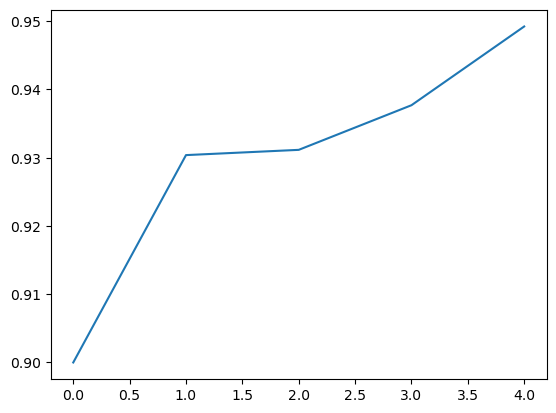

In [20]:
plt.plot(history.history['val_acc'])

In [21]:
X_train

array([[    0,     0,     0, ...,    12,   243,  7254],
       [    4,    65,   103, ...,    12,     1, 11523],
       [    0,     0,     0, ...,     1,   148,   137],
       ...,
       [    0,     0,     0, ...,   896,    22,   517],
       [    0,     0,     0, ...,     5, 11114,  3515],
       [ 1392,  3747,     6, ...,    21,    27,   327]], dtype=int32)

In [22]:
model.evaluate(X_test, y_test)


163/163 [==============================] - 102s 626ms/step - loss: 0.1413 - acc: 0.9492


[0.14129845798015594, 0.9492307901382446]

In [24]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

163/163 [==============================] - 106s 642ms/step


In [25]:

import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, ..., 0, 0, 0])

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[2542,   71],
       [ 193, 2394]])

Text(50.722222222222214, 0.5, 'Truth')

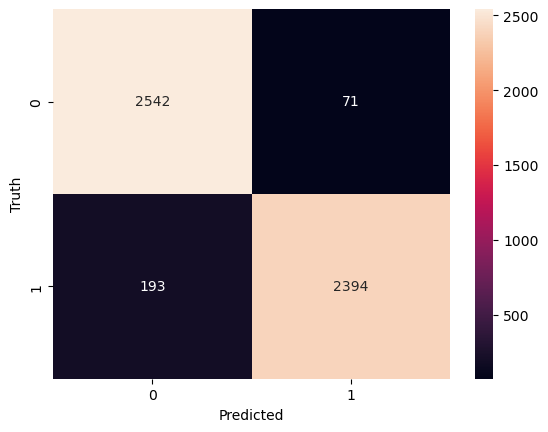

In [27]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [28]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2613
           1       0.97      0.93      0.95      2587

    accuracy                           0.95      5200
   macro avg       0.95      0.95      0.95      5200
weighted avg       0.95      0.95      0.95      5200

